# BI-LSTM model zonder mempool data

In [35]:
# Import data
import pandas as pd

# Read the dataset without mempool data
df = pd.read_csv('C:/Users/boris/Documents/M&T/Financial Innovation/Afstuderen/Scriptie/Feature_engineering/df_geen_mempool.csv')


In [36]:
df= df.drop(columns = 'regime_change')

In [37]:
df

,Timestamp,Open,High,Low,Close,Volume,value,value_classification,daily_std,MA7,MA30,market_regime
0,2018-02-01,9974.91,10187.56,8820.96,8970.00,20517.085284,30.0,Fear,683.300,10602.648571,12637.540000,1
1,2018-02-02,8970.00,9234.10,7625.25,8580.00,47828.982222,15.0,Extreme Fear,804.425,10250.204286,12429.063333,1
2,2018-02-03,8551.19,9443.96,8170.71,9386.72,17968.929040,40.0,Fear,636.625,9956.165714,12249.274000,1
3,2018-02-04,9391.30,9491.20,8189.32,8301.65,14407.720751,24.0,Extreme Fear,650.940,9484.974286,11980.415000,1
4,2018-02-05,8301.65,8416.03,6865.66,6877.61,37314.242065,11.0,Extreme Fear,775.185,8862.992857,11650.574333,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2660,2025-05-15,103514.00,104184.00,101442.00,103793.00,1339.093301,70.0,Greed,1371.000,103740.571429,95361.833333,0
2661,2025-05-16,103800.00,104570.00,103137.00,103506.00,994.760377,71.0,Greed,716.500,103814.142857,96010.500000,0
2662,2025-05-17,103503.00,103720.00,102668.00,103153.00,459.809889,74.0,Greed,526.000,103577.571429,96617.133333,0
2663,2025-05-18,103172.00,106635.00,103149.00,106520.00,905.179396,74.0,Greed,1743.000,103919.142857,97352.200000,0


In [38]:
# Check for missing values in the 'value' column
print("Number of missing values in 'value' column:", df['value'].isna().sum())

# Interpolate missing values in the 'value' column using linear interpolation
df['value'] = df['value'].interpolate(method='linear')

# Verify that all missing values are filled
print("Number of missing values after interpolation:", df['value'].isna().sum())


Number of missing values in 'value' column: 4
Number of missing values after interpolation: 0


Om te zorgen dat exact dezelfde data als het model met mempooldata wordt gebruikt, zorg ik dat de datums in df: 
- First date in dataset: 2018-02-01
- Last date in dataset: 2025-05-10 

In [39]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filter data between start and end dates
start_date = '2018-02-01'
end_date = '2025-05-10'

df = df[(df['Timestamp'] >= start_date) & (df['Timestamp'] <= end_date)]

# Reset index after filtering
df = df.reset_index(drop=True)


In [40]:
# pip install tensorflow


In [41]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM


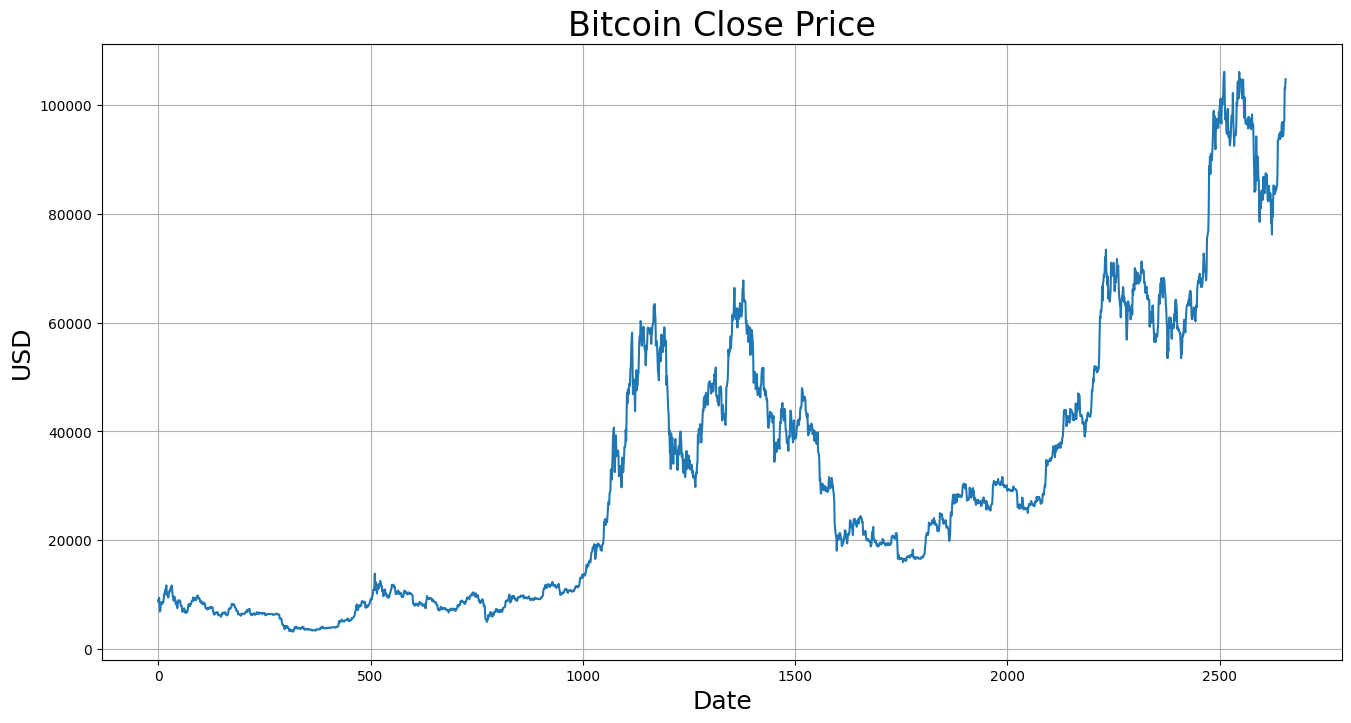

In [42]:
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.grid(True)
plt.show()


In [43]:
feature_columns = ['Close', 'Volume', 'value', 'daily_std', 'MA7', 'MA30', 'market_regime']

# Maak features en target sets
features = df[feature_columns].values  # numpy array van alle features
target = df[['Close']].values  # Doel is nog steeds de Close prijs

# Train-val-test splits indices zoals eerder
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

train_end = train_size
val_end = train_size + val_size

In [44]:
# Splits features en target in train, val, test
train_features = features[:train_end]
val_features = features[train_end:val_end]
test_features = features[val_end:]

train_target = target[:train_end]
val_target = target[train_end:val_end]
test_target = target[val_end:]

In [45]:
# Normaliseer ALLE features op basis van training set
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_features)
val_scaled = scaler.transform(val_features)
test_scaled = scaler.transform(test_features)

In [46]:
# Target schaal apart houden en fitten op train target
target_scaler = MinMaxScaler(feature_range=(0,1))
train_target_scaled = target_scaler.fit_transform(train_target)
val_target_scaled = target_scaler.transform(val_target)
test_target_scaled = target_scaler.transform(test_target)

In [47]:
# Sequenties maken (nu voor alle features)
def create_sequences(features, target, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])  # alle features in sequentie
        y.append(target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, train_target_scaled)
X_val, y_val = create_sequences(val_scaled, val_target_scaled)
X_test, y_test = create_sequences(test_scaled, test_target_scaled)

# Check shapes
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)

X_train shape: (1799, 60, 7)
y_train shape: (1799, 1)


# Baseline Architectuur opzetten

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

# Bi-LSTM model volgens Figure 6 uit het paper
model = Sequential()
model.add(Bidirectional(
    LSTM(units=64, return_sequences=False),  # gebruik alleen output van laatste tijdstap
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dense(units=1))  # output = voorspelling van Close op dag t+1

# Compileer model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\boris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Iteratie 1

In [98]:
# Train model with early stopping and validation data
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0322 - val_loss: 0.0095
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.8407e-04 - val_loss: 0.0012
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 8.6607e-04 - val_loss: 0.0013
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.4804e-04 - val_loss: 0.0015
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.1405e-04 - val_loss: 0.0014
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.8600e-04 - val_loss: 0.0013
Epoch 12/100
29/29 ━━━━━━━━━━━━━

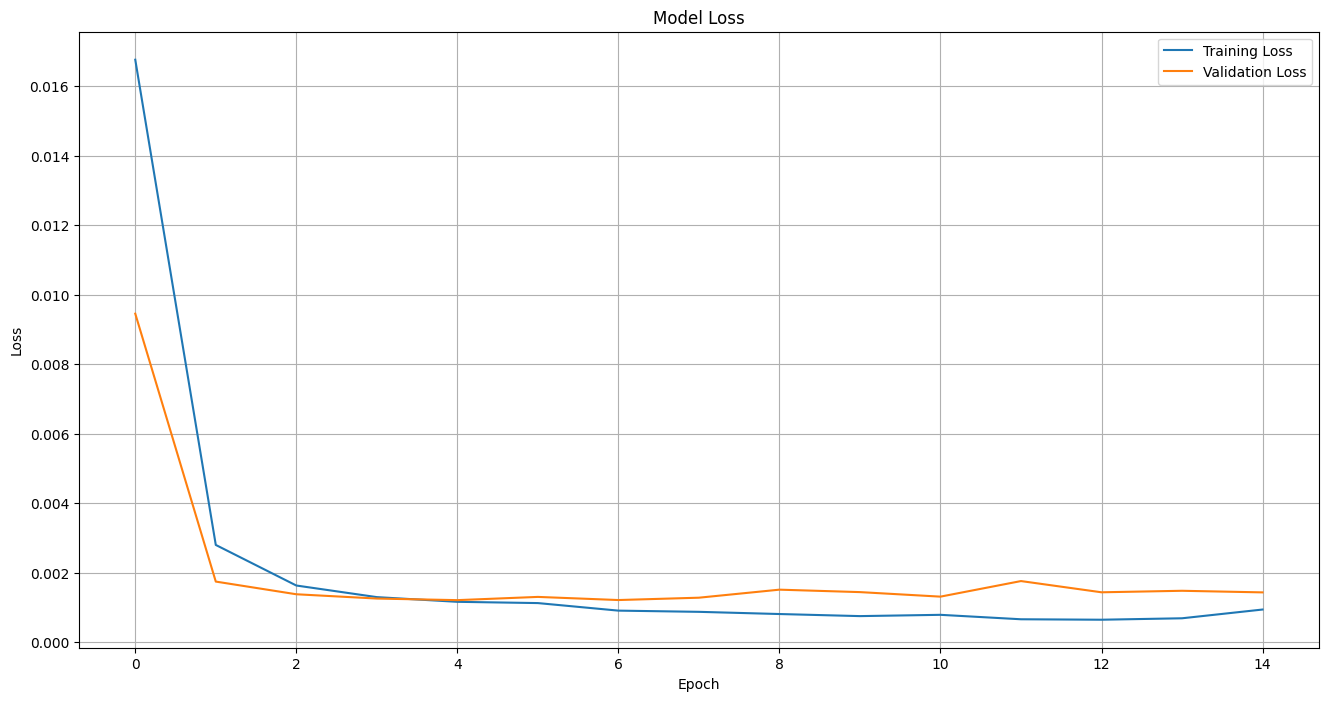

In [99]:
# Plot training and validation loss
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error

# Make predictions on validation set
val_predictions = model.predict(X_val)

# Calculate RMSE on unscaled predictions
val_rmse = np.sqrt(mean_squared_error(
    target_scaler.inverse_transform(y_val.reshape(-1, 1)),
    target_scaler.inverse_transform(val_predictions)
))

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((target_scaler.inverse_transform(y_val.reshape(-1, 1)) - 
                       target_scaler.inverse_transform(val_predictions)) / 
                       target_scaler.inverse_transform(y_val.reshape(-1, 1)))) * 100

print(f'Validation RMSE: ${val_rmse:,.2f}')
print(f'Validation MAPE: {mape:.2f}%')


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Validation RMSE: $2,246.24
Validation MAPE: 4.52%


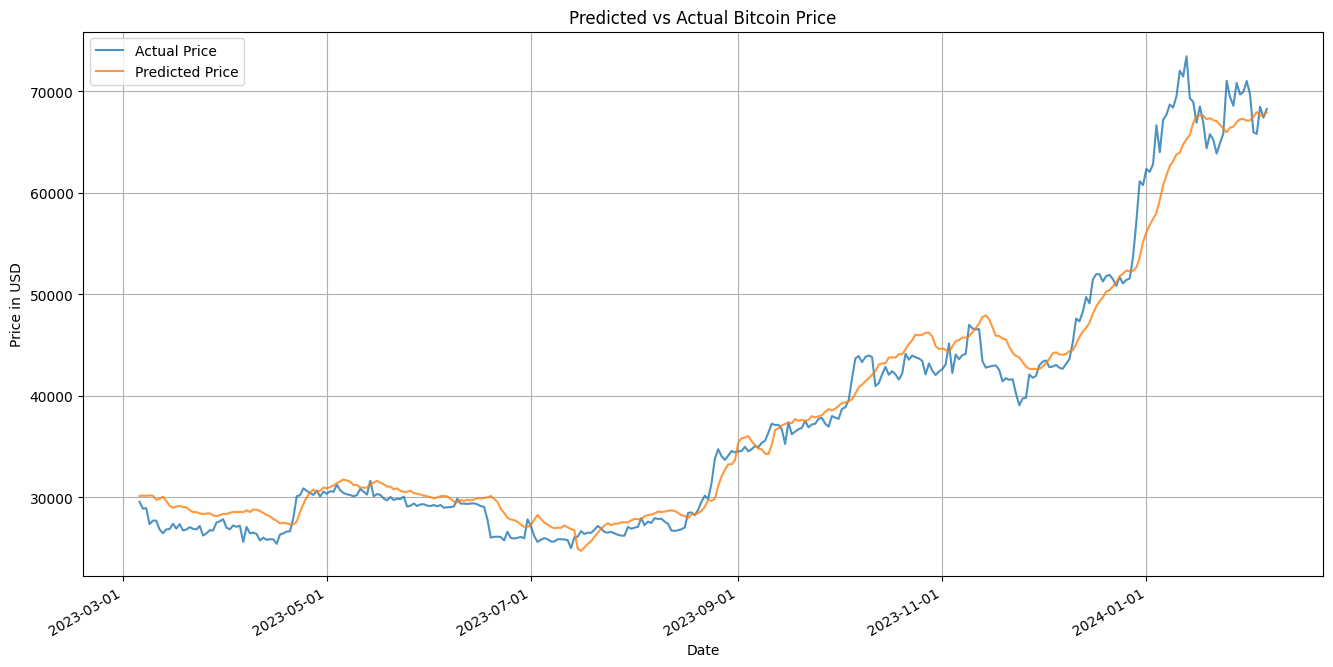

In [102]:
# First define training size and sequence length
training_size = len(X_train)
sequence_length = X_train.shape[1]  # Get sequence length from training data shape

# Get the dates corresponding to validation set
val_dates = df['Timestamp'][training_size+sequence_length:training_size+len(y_val)+sequence_length]

# Show the unscaled version
unscaled_y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions = target_scaler.inverse_transform(val_predictions)

plt.figure(figsize=(16, 8))
plt.plot(val_dates, unscaled_y_val, label='Actual Price', alpha=0.8)
plt.plot(val_dates, unscaled_predictions, label='Predicted Price', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis to show dates properly
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
from matplotlib.dates import DateFormatter
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.show()


# Iteratie 2: 

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

# Bi-LSTM model met extra Dense-laag
model_iteration2 = Sequential()
model_iteration2.add(Bidirectional(
    LSTM(units=64, return_sequences=False),
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model_iteration2.add(Dense(units=32, activation='relu'))  # extra Dense-laag
model_iteration2.add(Dense(units=1))  # outputlaag

# Compileer model
model_iteration2.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\boris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# Train model with early stopping and validation data
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_iteration2 = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True
)

history_iteration2 = model_iteration2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_iteration2],
    verbose=1
)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0182 - val_loss: 0.0033
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 9.1900e-04 - val_loss: 0.0014
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.5195e-04 - val_loss: 0.0012
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.3221e-04 - val_loss: 0.0014
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6.9159e-04 - val_loss: 0.0015
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.9044e-04 - val_loss: 0.0012
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.7385e-04 - val_loss: 0.0014
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.0029e-04 - val_loss: 0.0019
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.8762e-04 - val_loss: 0.0019
Epoch 12/100
57/57 ━

In [60]:
# Make predictions on validation set
val_predictions_iteration2 = model_iteration2.predict(X_val)

# Unscale predictions and actual values
unscaled_y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions = target_scaler.inverse_transform(val_predictions_iteration2)

# Calculate RMSE
val_rmse_iteration2 = np.sqrt(mean_squared_error(unscaled_y_val, unscaled_predictions))

# Calculate MAPE
val_mape_iteration2 = np.mean(np.abs((unscaled_y_val - unscaled_predictions) / unscaled_y_val)) * 100

print(f"Validation RMSE (Iteration 2): ${val_rmse_iteration2:,.2f}")
print(f"Validation MAPE (Iteration 2): {val_mape_iteration2:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Validation RMSE (Iteration 2): $1,768.66
Validation MAPE (Iteration 2): 2.86%


# Iteratie 3: 

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model_iteration3 = Sequential()
model_iteration3.add(Bidirectional(
    LSTM(50, return_sequences=True),
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model_iteration3.add(Bidirectional(
    LSTM(50, return_sequences=False)
))
model_iteration3.add(Dense(25))
model_iteration3.add(Dense(1))

# Compile model with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_iteration3.compile(optimizer=optimizer, loss='mean_squared_error')

# Train model with early stopping
early_stopping_iteration3 = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_iteration3 = model_iteration3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_iteration3],
    verbose=1
)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.0910 - val_loss: 0.0105
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/st

In [80]:
# Calculate validation RMSE and MAPE for iteration 3
val_predictions_iter3 = model_iteration3.predict(X_val)

# Unscale predictions and actual values
unscaled_y_val_iter3 = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions_iter3 = target_scaler.inverse_transform(val_predictions_iter3)

# Calculate RMSE
val_rmse_iter3 = np.sqrt(mean_squared_error(unscaled_y_val_iter3, unscaled_predictions_iter3))

# Calculate MAPE
val_mape_iter3 = np.mean(np.abs((unscaled_y_val_iter3 - unscaled_predictions_iter3) / unscaled_y_val_iter3)) * 100

print(f"Validation RMSE Iteration 3: ${val_rmse_iter3:,.2f}")
print(f"Validation MAPE Iteration 3: {val_mape_iter3:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Validation RMSE Iteration 3: $2,581.90
Validation MAPE Iteration 3: 4.98%


# Grid Search

In [70]:
# import itertools
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Bidirectional
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import mean_squared_error

# # Define parameter grid
# param_grid = {
#     'units': [25, 64, 150],  # Units per layer
#     'num_layers': [1], 
#     'bidirectional': [True],  # Always True for this setup
#     'dropout': [0.0, 0.2, 0.3],
#     'recurrent_dropout': [0.0, 0.2, 0.3],
#     'batch_size': [16, 32, 64],
#     'learning_rate': [0.01, 0.005, 0.001],
#     'epochs': [100]
# }

# # Key list
# base_keys = ['units', 'num_layers', 'bidirectional','dropout', 'recurrent_dropout', 'batch_size', 'learning_rate', 'epochs']
# base_values = [param_grid[k] for k in base_keys]
# base_combinations = list(itertools.product(*base_values))

# results = []

# for base in base_combinations:
#     config = dict(zip(base_keys, base))

#     tf.keras.backend.clear_session()

#     model = Sequential()
#     model.add(Bidirectional(LSTM(units=config['units'],
#                             return_sequences=False,
#                             dropout=config['dropout'], 
#                             recurrent_dropout=config['recurrent_dropout']),
#                             input_shape=(X_train.shape[1], X_train.shape[2])))

#     model.add(Dense(25))  # Intermediate layer
#     model.add(Dense(1))  # Output layer

#     model.compile(optimizer=Adam(learning_rate=config['learning_rate']), loss='mean_squared_error')

#     early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#     history = model.fit(X_train, y_train,
#                         validation_data=(X_val, y_val),
#                         epochs=config['epochs'],
#                         batch_size=config['batch_size'],
#                         callbacks=[early_stop],
#                         verbose=0)

#     val_pred = model.predict(X_val, verbose=0)
#     rmse = np.sqrt(mean_squared_error(y_val, val_pred))

#     results.append({**config, 'val_rmse': rmse})

# # Select the best configuration
# best_config = min(results, key=lambda x: x['val_rmse'])

# print("\nBeste hyperparameters gevonden na grid search:")
# print("---------------------------------------------------------------")
# print(f"Number of units (LSTM): {best_config['units']}")
# print(f"Number of LSTM layers: {best_config['num_layers']}")
# print(f"Bidirectional: {best_config['bidirectional']}")
# print(f"Dropout: {best_config['dropout']}")
# print(f"Recurrent Dropout: {best_config['recurrent_dropout']}")
# print(f"Batch size: {best_config['batch_size']}")
# print(f"Learning rate: {best_config['learning_rate']}")
# print(f"Number of epochs: {best_config['epochs']} (early stopping was actief)")


# Model trainen op beste hyperparameters uit grid search

In [93]:
model_variant_bilstm = Sequential()
model_variant_bilstm.add(Bidirectional(
    LSTM(units=64, return_sequences=False),
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model_variant_bilstm.add(Dense(units=32))  # Extra dense layer met 32 units
model_variant_bilstm.add(Dense(units=1))  # output = voorspelling van Close op dag t+1

# Compile met aangepaste learning rate
model_variant_bilstm.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')

# Early stopping instellen
early_stop_bilstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train het aangepaste model
history_variant_bilstm = model_variant_bilstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_bilstm],
    verbose=1
)

# Calculate validation metrics
val_predictions_bilstm = model_variant_bilstm.predict(X_val)

# Unscale predictions and actual values
unscaled_y_val_bilstm = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions_bilstm = target_scaler.inverse_transform(val_predictions_bilstm)

# Calculate RMSE
val_rmse_bilstm = np.sqrt(mean_squared_error(unscaled_y_val_bilstm, unscaled_predictions_bilstm))

# Calculate MAPE
val_mape_bilstm = np.mean(np.abs((unscaled_y_val_bilstm - unscaled_predictions_bilstm) / unscaled_y_val_bilstm)) * 100

print(f"Validation RMSE Bi-LSTM: ${val_rmse_bilstm:,.2f}")
print(f"Validation MAPE Bi-LSTM: {val_mape_bilstm:.2f}%")


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 0.0516 - val_loss: 0.0061
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 9.4439e-04 - val_loss: 0.0016
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 9.7563e-04 - val_loss: 0.0015
Epoch 12/100
57/57 ━━━━━━━━━━━━

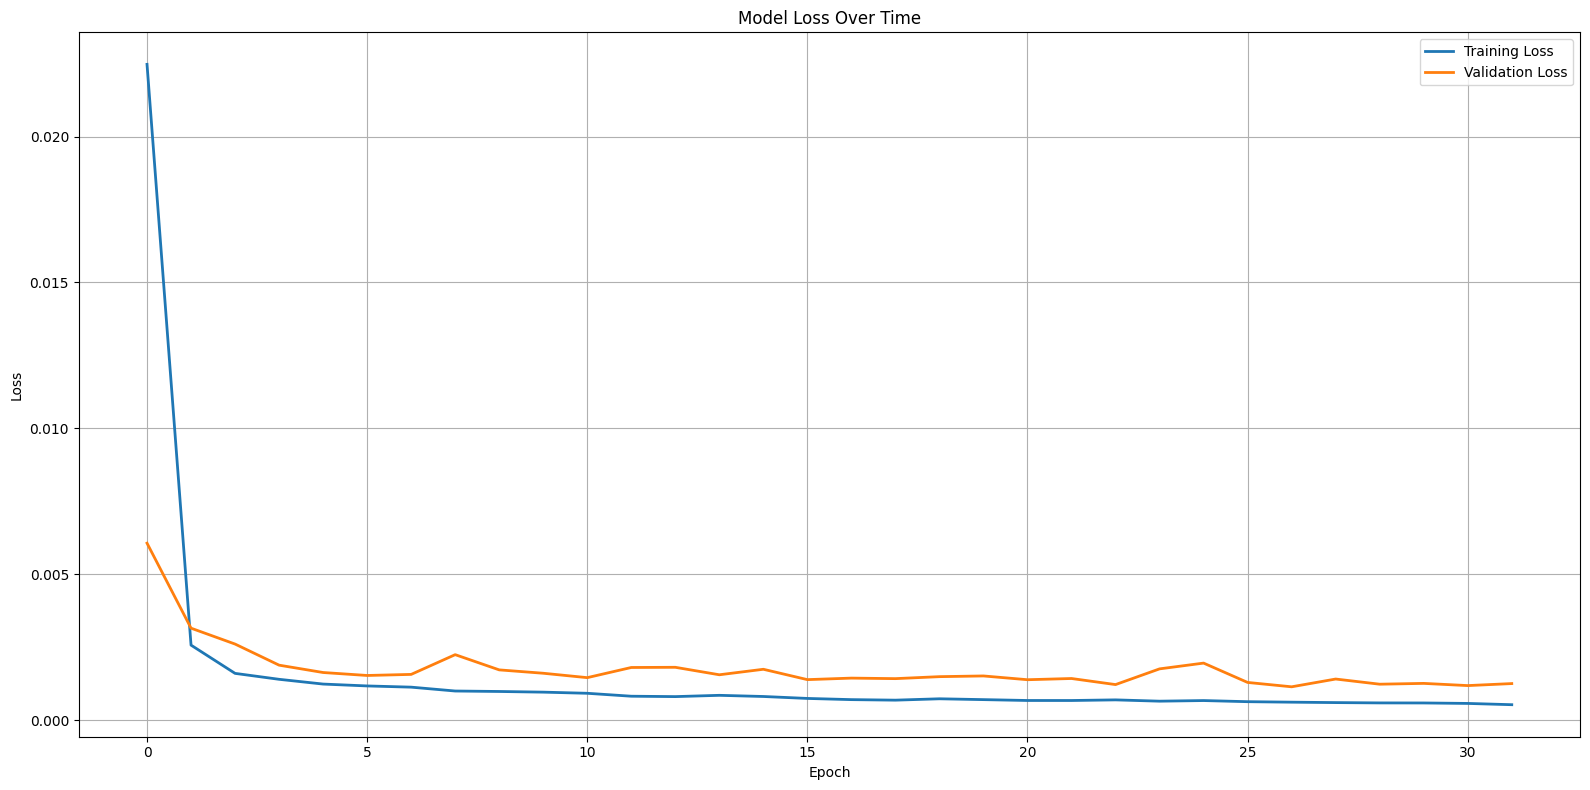

In [96]:
# Plot training and validation loss
plt.figure(figsize=(16, 8))
plt.plot(history_variant_bilstm.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_variant_bilstm.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Resultaten op de testset

In [94]:
# Calculate test metrics
test_predictions_bilstm = model_variant_bilstm.predict(X_test)

# Unscale predictions and actual values
unscaled_y_test_bilstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
unscaled_test_predictions_bilstm = target_scaler.inverse_transform(test_predictions_bilstm)

# Calculate RMSE
test_rmse_bilstm = np.sqrt(mean_squared_error(unscaled_y_test_bilstm, unscaled_test_predictions_bilstm))

# Calculate MAPE 
test_mape_bilstm = np.mean(np.abs((unscaled_y_test_bilstm - unscaled_test_predictions_bilstm) / unscaled_y_test_bilstm)) * 100

print(f"Test RMSE Bi-LSTM: ${test_rmse_bilstm:,.2f}")
print(f"Test MAPE Bi-LSTM: {test_mape_bilstm:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test RMSE Bi-LSTM: $9,420.51
Test MAPE Bi-LSTM: 8.85%


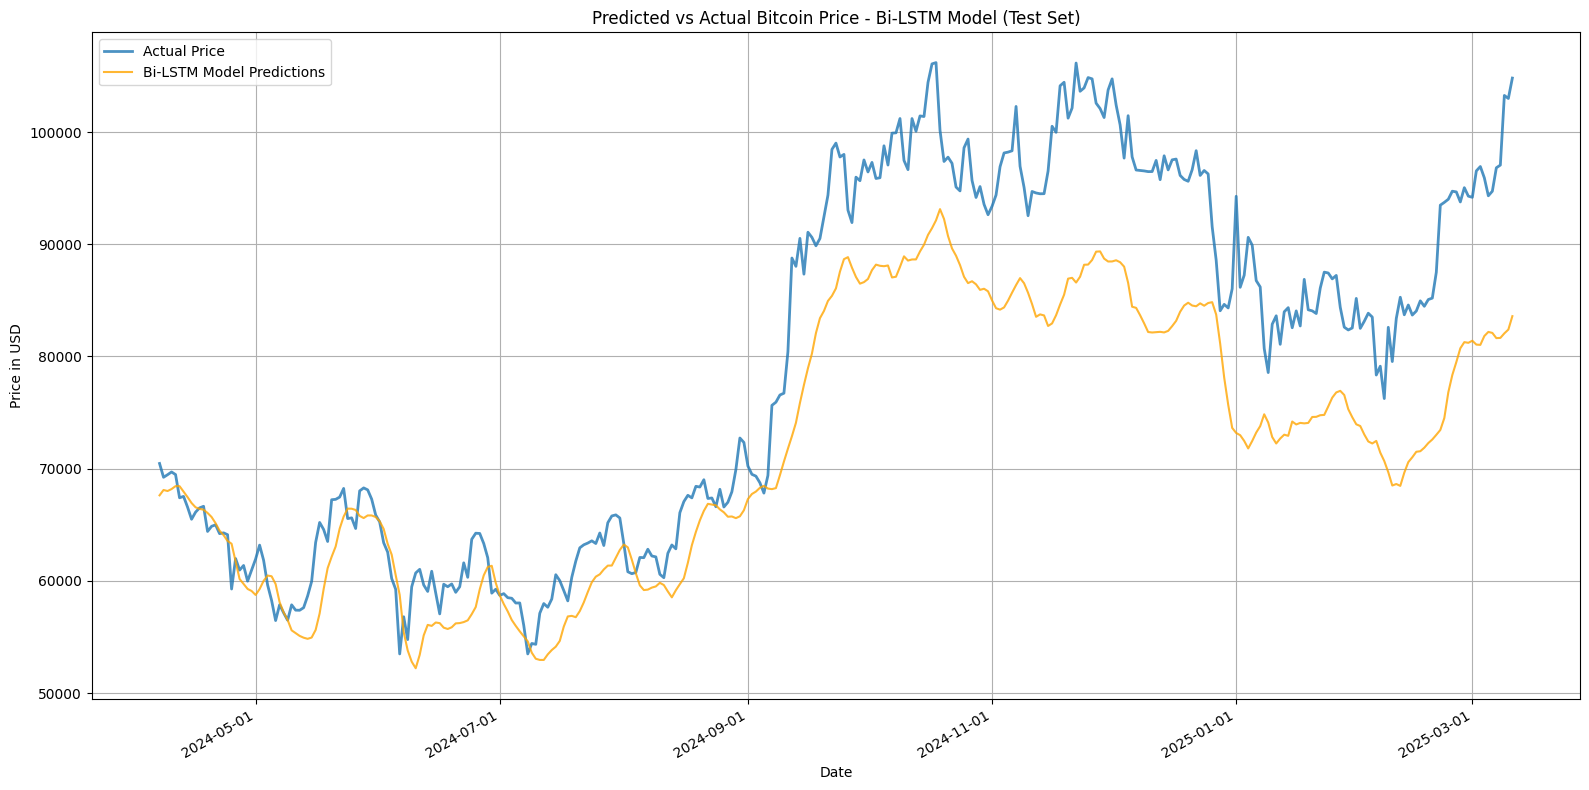

In [107]:
# Get test dates
test_dates = df['Timestamp'][training_size+val_size+sequence_length:training_size+val_size+len(y_test)+sequence_length]

# Create comparison plot
plt.figure(figsize=(16, 8))
plt.plot(test_dates, unscaled_y_test_bilstm, label='Actual Price', linewidth=2, alpha=0.8)
plt.plot(test_dates, unscaled_test_predictions_bilstm, label='Bi-LSTM Model Predictions', color='orange', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price - Bi-LSTM Model (Test Set)')
plt.xlabel('Date') 
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis dates
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


# Plots maken van de optimalisatie 

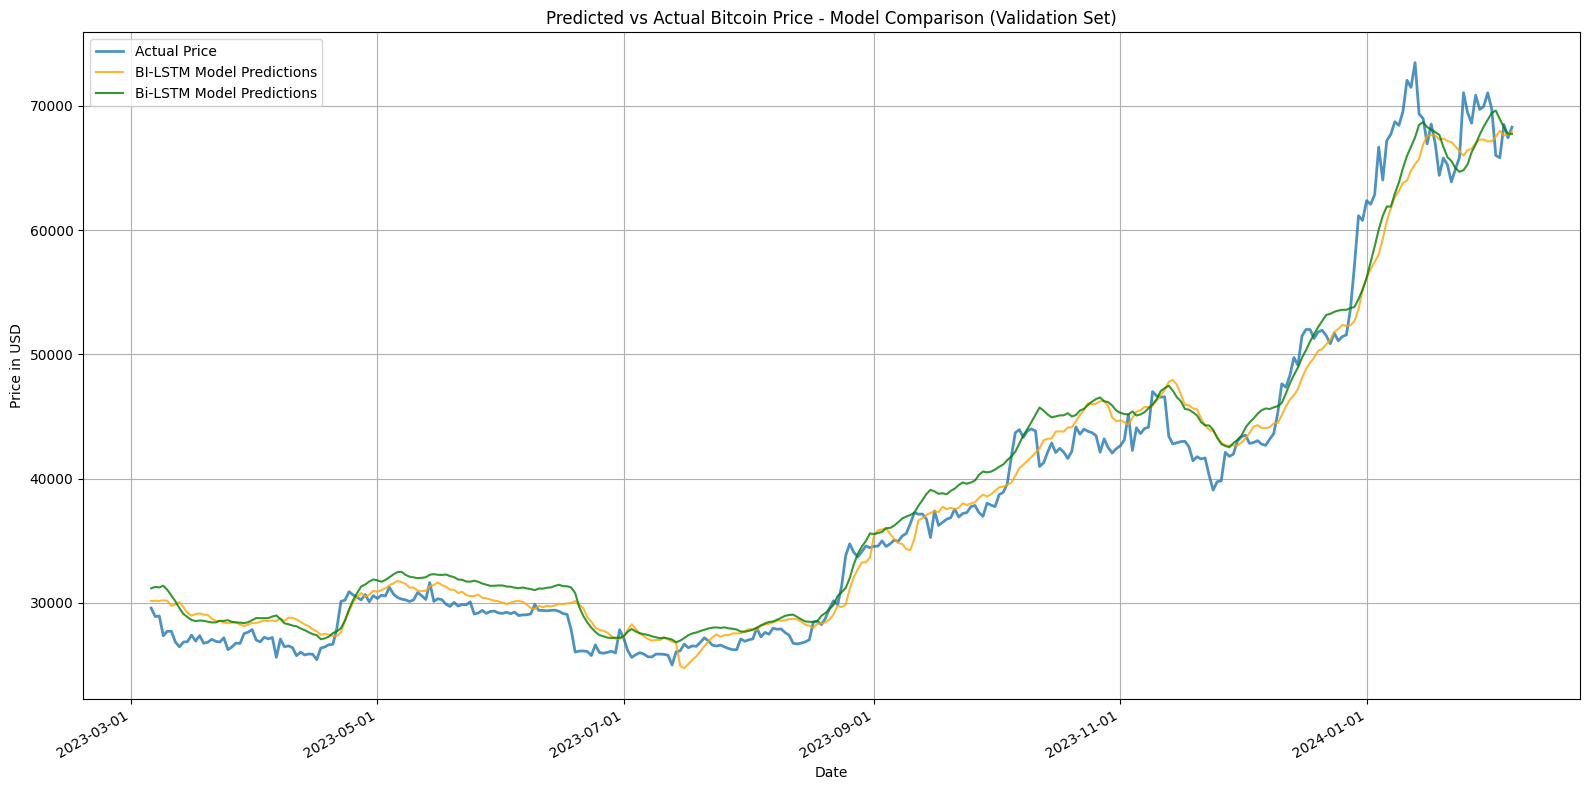

In [104]:
# Plot validation predictions for both models
plt.figure(figsize=(16, 8))
plt.plot(val_dates, unscaled_y_val, label='Actual Price', linewidth=2, alpha=0.8)
plt.plot(val_dates, unscaled_predictions, label='BI-LSTM Model Predictions', color='orange', alpha=0.8)
plt.plot(val_dates, unscaled_predictions_bilstm, label='Bi-LSTM Model Predictions', color='green', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price - Model Comparison (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis dates
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


# Beste baseline model resultaten opslaan: 

In [108]:
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Price': unscaled_y_test.flatten(),
    'Predicted_Price': unscaled_test_predictions_bilstm.flatten()
})

filename = f'bi_lstm_baseline_results_rmse_{rmse:.2f}_mape_{mape_score:.2f}.csv'
results_df.to_csv(filename, index=False)
